In [1]:
import glob, sys
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
import matplotlib.pyplot as plt
import re
import glob
from tensorflow.keras import backend as K
import tensorflow_probability as tfp
import ast
fft_size = 16777216
time_res = 64e-6 # in seconds
T_obs = (fft_size*time_res)/60 # in minutes is equal to 17.895 minutes
freq_axis = np.fft.rfftfreq(fft_size, d=64e-6)
freq_res = 1/(T_obs*60)

def find_indices(small_list, big_list):
    indices = []

    for item in small_list:
        if item in big_list:
            index = np.where(big_list == item)[0]
            indices.append(index[0])

    return indices


2023-07-27 12:40:24.884346: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
cur_dir = ''
root_dir = ''
run = 'runBC'
X_train = np.load(cur_dir + f'raw_data/{run}/train_data_chunk.npy').astype(np.float64)
X_test = np.load(cur_dir + f'raw_data/{run}/test_data_chunk.npy').astype(np.float64)
X_val = np.load(cur_dir + f'raw_data/{run}/val_data_chunk.npy').astype(np.float64)
X_train = X_train/np.max(X_train,axis=1)[:,None]
X_test = X_test/np.max(X_test,axis=1)[:,None]
X_val = X_val/np.max(X_val,axis=1)[:,None]

Y_train = np.load(cur_dir + f'raw_data/{run}/train_labels_chunk.npy').astype(np.float64)
Y_test = np.load(cur_dir + f'raw_data/{run}/test_labels_chunk.npy').astype(np.float64)
Y_val = np.load(cur_dir + f'raw_data/{run}/val_labels_chunk.npy').astype(np.float64)


# z_val = Y_val[:,1].copy()
# Y_val[:,0] = Y_val[:,0] - z_val
# Y_val[:,1] = Y_val[:,0] + z_val
# Y_val = np.sort(Y_val,axis=1)

# z_test = Y_test[:,1].copy()
# Y_test[:,0] = Y_test[:,0] - z_test
# Y_test[:,1] = Y_test[:,0] + z_test
# Y_test = np.sort(Y_test,axis=1)

# z_train = Y_train[:,1].copy()
# Y_train[:,0] = Y_train[:,0] - z_train
# Y_train[:,1] = Y_train[:,0] + z_train
# Y_train = np.sort(Y_train,axis=1)

Y_train[:,0] = np.abs(Y_train[:,0])
Y_test[:,0] = np.abs(Y_test[:,0])
Y_val[:,0] = np.abs(Y_val[:,0])

Y_train[:,1] = 2*np.abs(Y_train[:,1])
Y_test[:,1] = 2*np.abs(Y_test[:,1])
Y_val[:,1] = 2*np.abs(Y_val[:,1])

# Y_train = 2*np.abs(Y_train[:,1])
# Y_test = 2*np.abs(Y_test[:,1])
# Y_val = 2*np.abs(Y_val[:,1])

# # Y_train = Y_train/400
# # Y_test = Y_test/400
# # Y_val = Y_val/400

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1) 

Y_train = (Y_train.reshape(Y_train.shape[0],Y_train.shape[1], 1))
Y_val = (Y_val.reshape(Y_val.shape[0],Y_val.shape[1], 1))
Y_test = (Y_test.reshape(Y_test.shape[0],Y_test.shape[1], 1))

# Y_train = (Y_train.reshape(Y_train.shape[0],1))
# Y_val = (Y_val.reshape(Y_val.shape[0],1))
# Y_test = (Y_test.reshape(Y_test.shape[0],1))

train_indices = np.load(root_dir + f'raw_data/{run}/train_indices.npy')
test_indices = np.load(root_dir + f'raw_data/{run}/test_indices.npy')
val_indices = np.load(root_dir + f'raw_data/{run}/val_indices.npy')


In [3]:
snr_group = 1

if snr_group != -1:

    labels_df = pd.read_csv(root_dir + f'meta_data/labels_{run}.csv')
    #snr_range = labels_df['snr'].values
    snr_range = labels_df['z'].values
    #snr_bins = np.array([0.005 , 0.068, 0.126, 0.184, 0.242, 0.3  ])
    #snr_bins = np.array([0 , 5, 30])
    #snr_bins = np.array([0.005  , 0.00625, 0.0075 , 0.00875, 0.01   ])
    #snr_bins = np.array([ 0.        , 16.66666667, 33.33333333, 50.        ])
    snr_bins = np.array([-100,0,100])
    #snr_bins = np.array([ 0.        ,  5.55555556, 11.11111111, 16.66666667, 22.22222222,
    #   27.77777778, 33.33333333, 38.88888889, 44.44444444, 50.        ])

    train_indices_group = labels_df['# ind'][(snr_range > snr_bins[snr_group]) & (snr_range < snr_bins[snr_group + 1]) & (labels_df['status'] == 'train')].values
    test_indices_group = labels_df['# ind'][(snr_range > snr_bins[snr_group]) & (snr_range < snr_bins[snr_group + 1]) & (labels_df['status'] == 'test')].values
    val_indices_group = labels_df['# ind'][(snr_range > snr_bins[snr_group]) & (snr_range < snr_bins[snr_group + 1]) & (labels_df['status'] == 'val')].values

    train_indices_small = find_indices(train_indices_group, train_indices)
    test_indices_small = find_indices(test_indices_group, test_indices)
    val_indices_small = find_indices(val_indices_group, val_indices)

    X_train = X_train[train_indices_small]
    X_test = X_test[test_indices_small]
    X_val = X_val[val_indices_small]

    Y_train = Y_train[train_indices_small]
    Y_test = Y_test[test_indices_small]
    Y_val = Y_val[val_indices_small]

    train_indices = train_indices[train_indices_small]
    test_indices = test_indices[test_indices_small]
    val_indices = val_indices[val_indices_small]

In [4]:
test_rslices = np.load(cur_dir + f'raw_data/{run}/test_rslices.npy')
train_rslices = np.load(cur_dir + f'raw_data/{run}/train_rslices.npy')
val_rslices = np.load(cur_dir + f'raw_data/{run}/val_rslices.npy')

test_rslices = test_rslices[test_indices_small]
train_rslices = train_rslices[train_indices_small]
val_rslices = val_rslices[val_indices_small]

In [5]:
max_val_slice = np.max(val_rslices,axis=1)
max_test_slice = np.max(test_rslices,axis=1)
max_train_slice = np.max(train_rslices,axis=1)
# concatenating rslices
rslices = np.concatenate([test_rslices, train_rslices, val_rslices], axis=0)

# concatenating max_r_slices
max_r_slices = np.concatenate([max_val_slice, max_test_slice, max_train_slice], axis=0)

Y = np.concatenate([Y_val,Y_test,Y_train], axis=0)

In [6]:
cur_dir = ''
run = 'runBC'
#test_indices = np.load(cur_dir + f'raw_data/{run}/test_indices.npy')
labels_df = pd.read_csv(cur_dir + f'meta_data/labels_{run}.csv')

In [7]:
def period_accuracy(Y_test, Y_pred):
    """
    Computes the percentage of predicted periods that are within 0.5% of the true periods.
    """
    accuracies = []
    nan_indices = []
    Y_test = tf.cast(Y_test, tf.float32)
    Y_pred = tf.cast(Y_pred, tf.float32)
    shape = Y_test.shape[1]
    for i in range(shape):
        Y_test_i = Y_test[:,i]
        Y_pred_i = Y_pred[:,i]
        
        nan_mask = tf.math.is_nan(Y_test_i)
        nan_indices.append(tf.where(nan_mask))
        
        Y_test_i = tf.boolean_mask(Y_test_i, tf.logical_not(nan_mask))
        Y_pred_i = tf.boolean_mask(Y_pred_i, tf.logical_not(nan_mask))

        rat = (Y_test_i + 1e-10)/(Y_pred_i + 1e-10)
        rat_bool = tf.logical_and(tf.less(rat, 1.005), tf.greater(rat, 0.995))
        accuracy = tf.reduce_mean(tf.cast(rat_bool, tf.float32)) * 100
        accuracies.append(accuracy)
    return [acc.numpy() for acc in accuracies], nan_indices


def median_percent_deviation(Y_test, Y_pred):
    """
    Computes the median percent deviation from the predicted period.
    """
    Y_test = tf.cast(Y_test, tf.float32)
    Y_pred = tf.cast(Y_pred, tf.float32)
    median_deviations = []
    nan_indices = []
    shape = Y_test.shape[1]
    for i in range(shape):
        Y_test_i = Y_test[:,i]
        Y_pred_i = Y_pred[:,i]

        nan_mask = tf.math.is_nan(Y_test_i)
        nan_indices.append(tf.where(nan_mask))

        Y_test_i = tf.boolean_mask(Y_test_i, tf.logical_not(nan_mask))
        Y_pred_i = tf.boolean_mask(Y_pred_i, tf.logical_not(nan_mask))

        percent_deviation = tf.abs((Y_test_i - Y_pred_i) / (Y_test_i + 1e-10)) * 100
        median_deviation = tfp.stats.percentile(percent_deviation, q=50)
        median_deviations.append(median_deviation)

    return [med.numpy() for med in median_deviations], nan_indices


In [26]:
z_true = 2*labels_df['z'].abs().values.reshape(-1,1)[test_indices]
z_pred = 2*labels_df['z_max_from_pvol'].abs().values.reshape(-1,1)[test_indices]

In [30]:
period_accuracy(z_true, z_pred)

([13.288288],
 [<tf.Tensor: shape=(0, 1), dtype=int64, numpy=array([], shape=(0, 1), dtype=int64)>])

In [32]:
median_percent_deviation(z_pred, z_true)

([2.3214846], [<tf.Tensor: shape=(1, 1), dtype=int64, numpy=array([[321]])>])

In [6]:
for x_lab in ['period', 'snr', 'width', 'bper', 'binc', 'bcmass',
       'bphase', 'a', 'p_middle', 'pd', 'z', 'a_max',
       'z_max', 'p_fold', 'asini', 'periastron_time_mjd', 'fold_snr_theory' ]:
    X = labels_df[x_lab].values[test_indices.astype(int)]
    y = np.abs((Y_test[:,1] - Y_pred))
    
    #Make 2 subplots
    fig, axs = plt.subplots(1, 2, figsize=(13, 5))
    axs[0].plot(X, y, 'o')
    axs[0].set_ylim(0,10)
    axs[1].hist(X, bins=100)
    axs[1].set_xlabel(x_lab)
   #  axs[2].hist(y, bins=100)
   #  axs[2].set_xlabel('y   '+x_lab)
    plt.show()
    plt.close()

NameError: name 'Y_pred' is not defined

In [9]:
best_modelz_runBD = tf.keras.models.load_model("models/low_snr_predict_attention_2548494_checkpoint.h5")

2023-07-27 12:44:02.917540: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-07-27 12:44:02.919963: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-07-27 12:44:03.542300: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-07-27 12:44:03.542393: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (hercules11): /proc/driver/nvidia/version does not exist
2023-07-27 12:44:03.544119: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler

In [10]:
best_modelz_runBD.evaluate(X_test, Y_test)

2023-07-27 12:49:23.467751: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2023-07-27 12:49:24.710420: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2400000000 Hz


33/33 [==============================] - 16s 99ms/step - loss: 16401.6934 - mse: 16401.6934 - mae: 77.0031


[16401.693359375, 16401.693359375, 77.00310516357422]

In [19]:
X_test.shape

(1034, 400, 1)

In [16]:
model.evaluate(X_test, Y_test)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Instructions for updating:
Use fn_output_signature instead


ValueError: in user code:

    /u/atya/conda-envs/tf-gpu4/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1233 test_function  *
        return step_function(self, iterator)
    /tmp/ipykernel_246486/1515322706.py:19 None  *
        lambda y: find_z_ind(y_true_array, y)
    /tmp/ipykernel_246486/1515322706.py:9 find_z_ind  *
        return tf.argmin(tf.abs(z_array - z_value), axis=-1)
    /u/atya/conda-envs/tf-gpu4/lib/python3.8/site-packages/tensorflow/python/ops/math_ops.py:1180 binary_op_wrapper
        raise e
    /u/atya/conda-envs/tf-gpu4/lib/python3.8/site-packages/tensorflow/python/ops/math_ops.py:1164 binary_op_wrapper
        return func(x, y, name=name)
    /u/atya/conda-envs/tf-gpu4/lib/python3.8/site-packages/tensorflow/python/util/dispatch.py:201 wrapper
        return target(*args, **kwargs)
    /u/atya/conda-envs/tf-gpu4/lib/python3.8/site-packages/tensorflow/python/ops/math_ops.py:561 subtract
        return gen_math_ops.sub(x, y, name)
    /u/atya/conda-envs/tf-gpu4/lib/python3.8/site-packages/tensorflow/python/ops/gen_math_ops.py:10316 sub
        _, _, _op, _outputs = _op_def_library._apply_op_helper(
    /u/atya/conda-envs/tf-gpu4/lib/python3.8/site-packages/tensorflow/python/framework/op_def_library.py:748 _apply_op_helper
        op = g._create_op_internal(op_type_name, inputs, dtypes=None,
    /u/atya/conda-envs/tf-gpu4/lib/python3.8/site-packages/tensorflow/python/framework/func_graph.py:590 _create_op_internal
        return super(FuncGraph, self)._create_op_internal(  # pylint: disable=protected-access
    /u/atya/conda-envs/tf-gpu4/lib/python3.8/site-packages/tensorflow/python/framework/ops.py:3528 _create_op_internal
        ret = Operation(
    /u/atya/conda-envs/tf-gpu4/lib/python3.8/site-packages/tensorflow/python/framework/ops.py:2015 __init__
        self._c_op = _create_c_op(self._graph, node_def, inputs,
    /u/atya/conda-envs/tf-gpu4/lib/python3.8/site-packages/tensorflow/python/framework/ops.py:1856 _create_c_op
        raise ValueError(str(e))

    ValueError: Dimensions must be equal, but are 5236 and 2 for '{{node custom_loss/map/while/sub}} = Sub[T=DT_FLOAT](custom_loss/map/while/sub/x, custom_loss/map/while/TensorArrayV2Read/TensorListGetItem)' with input shapes: [5236], [2].


In [7]:
# Load the best model after training
best_modelf_runBC = tf.keras.models.load_model('models/predict_f_runBC_cnn_2530278_checkpoint.h5') #low snrs models
best_modelz_runBC = tf.keras.models.load_model('models/low_snr_predict_attention_2538705_checkpoint.h5') # low snrs models 
best_modelf_runBB = tf.keras.models.load_model('models/f_predict_cnn_1280525_checkpoint.h5') # run BB high snrs models
best_modelz_runBB = tf.keras.models.load_model('models/f_predict_attention_z_fine_1231538_55_checkpoint.h5') # runBB high snrs models 
best_modelf_runBD = tf.keras.models.load_model('models/tuner_predict_cnn_2542009_350_checkpoint.h5') # run BD high snrs models
best_modelz_runBD = tf.keras.models.load_model('models/tuner_predict_attention_z_2535741_853_checkpoint.h5') # runBD high snrs models 
# best_modelf = tf.keras.models.load_model('models/low_snr_predict_cnn_1585085_checkpoint.h5') #high snrs models
# best_modelz = tf.keras.models.load_model('models/low_snr_predict_attention_1585217_checkpoint.h5') # high snrs models 

#snr_predict = tf.keras.models.load_model('models/snr_predict_attention_1567308_checkpoint.h5')

z_pred_runBD = best_modelz_runBD.predict(X_test)
f_pred_runBD = best_modelf_runBD.predict(X_test)

# z_pred_runBC = best_modelz_runBC.predict(X_test)
# f_pred_runBC = best_modelf_runBC.predict(X_test)

Y_pred_runBD = np.concatenate((f_pred_runBD,z_pred_runBD),axis=1).reshape(Y_test.shape[0],Y_test.shape[1],1)
# Y_pred_runBC = np.concatenate((f_pred_runBC,z_pred_runBC),axis=1).reshape(Y_test.shape[0],Y_test.shape[1],1)

2023-07-21 11:39:29.525297: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-07-21 11:39:29.526357: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-07-21 11:39:30.136301: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-07-21 11:39:30.136384: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (hercules11): /proc/driver/nvidia/version does not exist
2023-07-21 11:39:30.137983: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler

In [15]:
z_presto = 2*labels_df.loc[test_indices]['z_presto_ACCEL_1200'].abs().values.reshape(test_indices.shape[0],1)
f_presto = ((1/(labels_df.loc[test_indices]['p_presto_ACCEL_1200']*freq_res)) - labels_df.loc[test_indices]['chunk_start']).values.reshape(test_indices.shape[0],1)

In [16]:
Y_presto = np.concatenate((f_presto,z_presto),axis=1).reshape(Y_test.shape[0],Y_test.shape[1],1)

In [19]:
#Y_pred = Y_pred_runBD
for i in range(Y_test.shape[0]):
    ind = test_indices[i]
    chunk_index = labels_df.loc[ind,'chunk_start']
    freq = chunk_index + Y_pred[i,0]
    #freq2 = chunk_index + Y_test[i,1]
    labels_df.at[ind,'p_pred'] = 1/(freq*freq_res)
    # if freq1 < freq2:
    #     labels_df.at[ind,'pred_freq_index0'] = freq1
    #     labels_df.at[ind,'pred_freq_index1'] = freq2

for i in range(Y_test.shape[0]):
    ind = test_indices[i]
    z = labels_df.loc[ind,'z']
    if z > 0:
       labels_df.at[ind,'z_pred'] = Y_pred[i,1]/2
    else:
        labels_df.at[ind,'z_pred'] = -Y_pred[i,1]/2 

In [22]:
labels_df.to_csv('meta_data/labels_runBD.csv',index=False)

In [ ]:
snr_range = labels_df['snr'].values
snr_bins = np.array([0 ,0.01, 0.068, 0.126, 0.184, 0.242, 0.3  ])

for snr_group in [0,1,2,3,4,5]:

    train_indices_group = labels_df['# ind'][(snr_range > snr_bins[snr_group]) & (snr_range < snr_bins[snr_group + 1]) & (labels_df['status'] == 'train')].values
    test_indices_group = labels_df['# ind'][(snr_range > snr_bins[snr_group]) & (snr_range < snr_bins[snr_group + 1]) & (labels_df['status'] == 'test')].values
    val_indices_group = labels_df['# ind'][(snr_range > snr_bins[snr_group]) & (snr_range < snr_bins[snr_group + 1]) & (labels_df['status'] == 'val')].values

    train_indices_small = find_indices(train_indices_group, train_indices)
    test_indices_small = find_indices(test_indices_group, test_indices)
    val_indices_small = find_indices(val_indices_group, val_indices)
    
    accuracy, _ = period_accuracy(Y_test[test_indices_small], Y_pred[test_indices_small])
    median, _ = median_percent_deviation(Y_test[test_indices_small], Y_pred[test_indices_small])
    print("Snr group: ",snr_group)
    print("Period accuracy: ", accuracy)
    print("Median percent deviation: ", median)
    # accuracy, _ = period_accuracy(Y_test[test_indices_small], Y_pred_high_snr[test_indices_small])
    # median, _ = median_percent_deviation(Y_test[test_indices_small], Y_pred_high_snr[test_indices_small])
    # print("Period accuracy high snr: ", accuracy)
    # print("Median percent deviation high snr: ", median)
    accuracy, _ = period_accuracy(Y_test[test_indices_small], Y_presto[test_indices_small])
    median, _ = median_percent_deviation(Y_test[test_indices_small], Y_presto[test_indices_small])
    print("Period accuracy presto: ", accuracy)
    print("Median percent deviation presto: ", median)
    print("##################################################### \n\n")

In [18]:
accuracy,nans_acc = period_accuracy(Y_pred, Y_test)
median,nans_med = median_percent_deviation(Y_pred, Y_test)
print("Period accuracy presto: ", accuracy)
print("Median percent deviation presto: ", median)

Period accuracy presto:  [12.462462, 2.027027]
Median percent deviation presto:  [3.5301273, 26.143143]


In [ ]:
files = glob.glob(f'/hercules/results/atya/BinaryML/sims/{run}/dat_inf_files/*_ACCEL_1200')
for i,file in enumerate(files):
    ind = int(file[60:-13])
    print(ind,file)
    actual_period = labels_df['p_middle'].loc[ind]
    with open(file) as f:
        con = f.readlines()
    periods = []
    cands = []
    for i in range(3,len(con)):
        if con[i] == '\n':
            break
        else:
            temp_list = re.findall(r'\d+\.\d+|\d+', con[i])
            cands.append(int(temp_list[0]))
            periods.append(float(temp_list[5])/1000)
    periods = np.array(periods)
    argmin = np.argmin(np.abs(periods-actual_period))
    labels_df.at[ind,'presto_nearest_period_accel_1200'] = periods[argmin]
    labels_df.at[ind,'presto_nearest_cand_num_accel_1200'] = cands[argmin]

In [7]:
run = 'runBD'
files_list_temp = glob.glob(f'/hercules/results/atya/BinaryML/sims/{run}/fold_output_pred/*pfd.bestprof')
list_dicts_temp = []

for i in range(len(files_list_temp)):
    file = files_list_temp[i]
    with open(file, 'r') as file:
        data_dict = {}
        for line in file:
            # Remove any new line characters
            line = line.strip()

            # Skip empty lines or comment lines
            if not line:
                continue
            if '###############################' in line:
                break
            # Split the line by the '=' character

            key,value = re.split('=|>|<', line)

            #key, value = line.split('=|>|<')

            # Remove any leading or trailing whitespace
            key = key.strip()[2:]
            value = value.strip()

            # Add the key-value pair to the dictionary
            data_dict[key] = value
        list_dicts_temp.append(data_dict)

In [8]:
for item in list_dicts_temp:
    temp = item['Prob(Noise)']
    temp_list = temp.split(' ')
    item['prob'] = float(temp_list[0])
    item['noise'] = float(temp_list[3][2:])
    temp_p = item['P_topo (ms)']
    item['p_presto']= float(temp_p.split('+/-')[0])
    temp_pd = item["P'_topo (s/s)"]
    item['pd_presto'] = float(temp_pd.split('+/-')[0])

In [9]:
for dic in list_dicts_temp:
    file_name = dic['Input file']
    if file_name in labels_df['file_name'].values:
        # labels_df.loc[labels_df['file_name']==file_name,'fold_snr_presto_ACCEL_1200'] = dic['noise']
        # labels_df.loc[labels_df['file_name']==file_name,'p_presto_ACCEL_1200'] = dic['p_presto']/1000
        # labels_df.loc[labels_df['file_name']==file_name,'pd_presto_ACCEL_1200'] = dic['pd_presto']
        labels_df.loc[labels_df['file_name']==file_name,'fold_snr_pred'] = dic['noise']


In [15]:
labels_df.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'period', 'snr', 'width', 'bper', 'binc',
       'bcmass', 'bphase', 'ind_orignal', '# ind', 'a', 'p_middle', 'pd', 'z',
       'a_max', 'z_max', 'p_fold', 'asini', 'periastron_time_mjd', 'file_name',
       'fold_snr_theory', 'file_found', 'status', 'chunk_start',
       'presto_nearest_period_accel_1200',
       'presto_nearest_cand_num_accel_1200', 'fold_snr_presto_ACCEL_1200',
       'p_presto_ACCEL_1200', 'pd_presto_ACCEL_1200', 'a_presto_ACCEL_1200',
       'z_presto_ACCEL_1200', 'fold_snr_true', 'p_pred', 'z_pred', 'a_pred',
       'pd_pred', 'p_fold_pred', 'fold_snr_pred', 'mismatch_presto',
       'mismatch_pred', 'mismatch_true'],
      dtype='object')

In [14]:
run = 'runBD'
labels_df.to_csv(f'meta_data/labels_{run}.csv',index=False)

In [13]:
labels_df['mismatch_presto'] = 1 - (labels_df['fold_snr_presto_ACCEL_1200']/labels_df['fold_snr_theory'])
labels_df['mismatch_pred'] = 1 - (labels_df['fold_snr_pred']/labels_df['fold_snr_theory'])
labels_df['mismatch_true'] = 1 - (labels_df['fold_snr_true']/labels_df['fold_snr_theory'])

In [24]:
p_dev = np.abs(labels_df.loc[test_indices]['p_presto_ACCEL_1200'] - labels_df.loc[test_indices]['p_fold'])
pd_dev = np.abs(labels_df.loc[test_indices]['pd_presto_ACCEL_1200'] - labels_df.loc[test_indices]['pd'])
p_std = np.std(p_dev)
pd_std = np.std(pd_dev)
print(np.std(p_dev),np.std(pd_dev))

0.008311647822182898 3.198728992330038e-08


In [27]:
# filter all values with period greater than 1 standard deviation
labels_df_fil = labels_df.loc[test_indices]
labels_df_fil = labels_df_fil[(labels_df_fil['p_presto_ACCEL_1200'] < ((labels_df_fil['p_fold'] + p_std))) & (labels_df_fil['p_presto_ACCEL_1200'] > ((labels_df_fil['p_fold'] - p_std)))]
labels_df_fil = labels_df_fil[(labels_df_fil['pd_presto_ACCEL_1200'] < ((labels_df_fil['pd'] + pd_std))) & (labels_df_fil['pd_presto_ACCEL_1200'] > ((labels_df_fil['pd'] - pd_std)))]

In [29]:
print(f"Presto accuracy : {len(labels_df_fil)/len(labels_df.loc[test_indices])}")

Presto accuracy : 0.8746246246246246


In [31]:
test_indices_fil = labels_df_fil['# ind'].values
# format in a table mismathes from true, presto, pred
print(labels_df_fil[['mismatch_true','mismatch_presto','mismatch_pred']].describe())

       mismatch_true  mismatch_presto  mismatch_pred
count    1165.000000      1165.000000    1165.000000
mean        0.046959         0.036560       0.275177
std         0.089792         0.120035       0.215631
min        -0.192308        -0.431373      -0.117647
25%        -0.006098        -0.012821       0.060000
50%         0.022472         0.019355       0.275862
75%         0.072917         0.069444       0.467066
max         0.573034         1.000000       0.751825


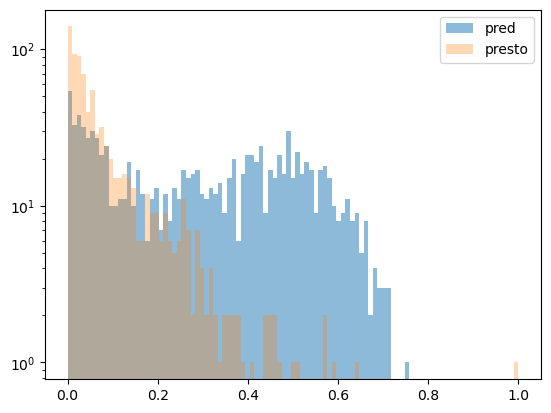

In [33]:
bins = np.linspace(0,1,100)
_ = plt.hist(labels_df_fil['mismatch_pred'],bins=bins,alpha=0.5,label='pred')
_ = plt.hist(labels_df_fil['mismatch_presto'],bins=bins,alpha=0.3,label='presto')
#scale y_axis
plt.yscale('log')
plt.legend()
#plt.savefig('plots/mismatch_pred_and_presto_runBC.png',dpi=300)

In [9]:
labels_df_fil = labels_df

In [35]:
labels_df_fil['z'].values - labels_df_fil['z_max_from_pvol'].values

array([        nan,         nan,  0.02571455, ...,  0.13047595,
       -0.75702569, -0.26333788])

In [36]:
np.abs(labels_df_fil['z'].values - labels_df_fil['z_presto_ACCEL_1200'].values)

array([1.69417053e-01, 8.03987025e+01, 1.17877462e-02, ...,
       3.98984307e+00, 3.28224093e-01, 2.63359664e-01])

In [37]:
labels_df_fil['z'].values

array([-10.45548043,  20.2717469 ,  -9.41178545, ...,   8.11485095,
       -37.27265069,  31.61166212])

In [53]:
median_percent_deviation(labels_df_fil['z_max_from_pvol'].values.reshape(-1,1),labels_df_fil['z'].values.reshape(-1,1))

([4.659102],
 [<tf.Tensor: shape=(9, 1), dtype=int64, numpy=
  array([[   0],
         [   1],
         [  23],
         [2342],
         [2351],
         [2979],
         [3028],
         [9943],
         [9945]])>])

In [41]:
np.mean(labels_df_fil['z_presto_ACCEL_1200'].values - labels_df_fil['z'].values)

nan

In [ ]:
for col in ['width', 'bper', 'binc', 'bcmass',
       'bphase', 'a', 'p_middle', 'z', 'a_max',
       'snr','fold_snr_theory']:
       #Make 2 subplots
       X = labels_df_fil[col].values
       fig, axs = plt.subplots(1, 3, figsize=(18, 5))
       _ = axs[2].hist(X, bins=100,color='cyan',label='all')
       axs[2].set_xlabel(col)
       axs[2].set_ylabel('Counts')
       
       Y = np.abs(labels_df_fil['z'].values - labels_df_fil['z_max_from_pvol'].values)
       
       sc = axs[1].scatter(X, Y, marker = '.',c=labels_df_fil['snr'].values,alpha=0.5,label='pred',cmap='viridis')
       axs[1].set_xlabel(col)
       axs[1].set_ylabel('z_deviation')
       #xs[1].set_ylim(-0.4,1)
       plt.colorbar(sc,ax=axs[1],label='snr')

       # axs[0].scatter(X, Y, marker = '.',c='maroon',alpha=0.5,label='pred')
       # axs[0].set_xlabel(col)
       # axs[0].set_ylabel('Mismatch')
       
       Y = np.abs(labels_df_fil['z'].values - labels_df_fil['z_presto_ACCEL_1200'].values)
       presto_scatter = axs[0].scatter(X, Y, marker='D', c=labels_df_fil['snr'].values, alpha=0.3, label='presto',cmap='viridis')
       presto_scatter.set_facecolor('none')


       plt.legend()
       plt.show()
       plt.close()

In [ ]:
for col in ['width', 'bper', 'binc', 'bcmass',
       'bphase', 'a', 'p_middle', 'z', 'a_max',
       'snr','fold_snr_theory']:
       #Make 2 subplots
       X = labels_df_fil[col].values
       fig, axs = plt.subplots(1, 3, figsize=(18, 5))
       _ = axs[2].hist(X, bins=100,color='cyan',label='all')
       axs[2].set_xlabel(col)
       axs[2].set_ylabel('Counts')
       
       Y = labels_df_fil['mismatch_pred'].values
       
       sc = axs[1].scatter(X, Y, marker = '.',c=labels_df_fil['snr'].values,alpha=0.5,label='pred',cmap='viridis')
       axs[1].set_xlabel(col)
       axs[1].set_ylabel('Mismatch')
       axs[1].set_ylim(-0.4,1)
       plt.colorbar(sc,ax=axs[1],label='snr')

       axs[0].scatter(X, Y, marker = '.',c='maroon',alpha=0.5,label='pred')
       axs[0].set_xlabel(col)
       axs[0].set_ylabel('Mismatch') 
       
       Y = labels_df_fil['mismatch_presto'].values
       presto_scatter = axs[0].scatter(X, Y, marker='D', c='blue',edgecolors='blue', alpha=0.3, label='presto')
       presto_scatter.set_facecolor('none')


       plt.legend()
       plt.show()
       plt.close()

In [ ]:
import matplotlib.gridspec as gridspec

for col in ['width', 'bper', 'binc', 'bcmass',
       'bphase', 'a', 'p_middle', 'z', 'a_max',
       'snr', 'fold_snr_theory']:
    X = labels_df_fil[col].values

    fig = plt.figure(figsize=(12, 4))
    gs = gridspec.GridSpec(1, 4, width_ratios=[3, 3, 1, 3],wspace=0)  # Adjust width ratios here
    
    axs = [plt.subplot(gs[i]) for i in [0, 1, 3]]  # Empty subplot at index 1 for padding

    axs[2].hist(X, bins=100, color='cyan', label='all')
    axs[2].set_xlabel(col)
    axs[2].set_ylabel('Counts')
       
    Y = labels_df_fil['mismatch_pred'].values

    sc = axs[1].scatter(X, Y, marker='.', c=labels_df_fil['snr'].values, alpha=0.5, label='pred', cmap='viridis')
    axs[1].set_xlabel(col)
    axs[1].set_ylim(-0.4, 1)
    plt.colorbar(sc, ax=axs[1], label='snr')

    axs[0].scatter(X, Y, marker='.', c='maroon', alpha=0.5, label='pred')
    axs[0].set_xlabel(col)
    axs[0].set_ylabel('Mismatch')

    Y = labels_df_fil['mismatch_presto'].values
    presto_scatter = axs[0].scatter(X, Y, marker='D', c='blue', edgecolors='blue', alpha=0.3, label='presto')
    presto_scatter.set_facecolor('none')

    # Set y-axis labels for axs[1] to match axs[0]
    axs[1].set_yticks(axs[0].get_yticks())
    axs[1].set_yticklabels(axs[0].get_yticklabels())

    plt.legend()
    plt.tight_layout()  # Adjust overall layout
    plt.show()
    plt.close()
    



In [ ]:
# Mismatch plots
mask = labels_df['status'] == 'test'
mismatch_pred = 1-labels_df[mask]['fold_snr_pred']/labels_df[mask]['fold_snr_thoery']
mask = ~labels_df['fold_snr_presto_ACCEL_1200'].isna()
mismatch_presto = 1-labels_df[mask]['fold_snr_presto_ACCEL_1200']/labels_df[mask]['fold_snr_thoery']
print(np.mean(mismatch_pred),np.median(mismatch_pred))
print(np.mean(mismatch_presto),np.median(mismatch_presto))
plt.text(0.1,0.9,f'pred: {np.mean(mismatch_pred):.3f}, {np.median(mismatch_pred):.3f}',transform=plt.gca().transAxes)
plt.text(0.1,0.8,f'presto: {np.mean(mismatch_presto):.3f}, {np.median(mismatch_presto):.3f}',transform=plt.gca().transAxes)
bins = np.linspace(0,1,100)
_ = plt.hist(mismatch_pred,bins=bins,alpha=0.5,label='pred')
_ = plt.hist(mismatch_presto,bins=bins,alpha=0.3,label='presto')
#scale y_axis
plt.yscale('log')
plt.legend()
#plt.savefig('plots/mismatch_pred_and_presto_runBC.png',dpi=300)

In [ ]:
# Mismatch plots
#mask = labels_df['status'] == 'test'
mask = ~labels_df['fold_snr_presto_ACCEL_1200'].isna()
mismatch_pred = 1-labels_df[mask]['fold_snr_presto_ACCEL_1200']/labels_df[mask]['fold_snr_theory']
print(np.mean(mismatch_pred),np.median(mismatch_pred))
_ = plt.hist(mismatch_pred,bins=100)

In [ ]:
mask = (~labels_df['fold_snr_presto_ACCEL_1200'].isna()) & (labels_df['fold_snr_theory']>5)
mismatch_pred = 1-labels_df[mask]['fold_snr_presto_ACCEL_1200']/labels_df[mask]['fold_snr_theory']
print(np.mean(mismatch_pred),np.median(mismatch_pred))
_ = plt.hist(mismatch_pred,bins=100,label='presto',alpha=0.3,color="green")
mask = (labels_df['fold_snr_theory']>5)
mismatch_true = 1-labels_df[mask]['fold_snr_true']/labels_df[mask]['fold_snr_theory']
print(np.mean(mismatch_true),np.median(mismatch_pred))
_ = plt.hist(mismatch_true,bins=100,label='true',alpha=0.3,color='red')
plt.xlabel('Mismatch')
plt.title('Mismatch distribution for presto and true')
plt.legend()

In [ ]:
#mask = np.ones((10000))#(~labels_df['fold_snr_presto_ACCEL_1200'].isna()) & (labels_df['fold_snr_theory']>10)
mismatch_pred = 1-labels_df['fold_snr_true']/labels_df['fold_snr_theory']
print(np.mean(mismatch_pred),np.median(mismatch_pred))
_ = plt.hist(mismatch_pred,bins=100)

In [ ]:
# Mismatch plots
mask = labels_df['status'] == 'test'
mismatch_pred = 1-labels_df[mask]['fold_snr_true']/labels_df[mask]['fold_snr_thoery']
print(np.mean(mismatch_pred),np.median(mismatch_pred))
_ = plt.hist(mismatch_pred,bins=100)

In [39]:
labels_df.to_csv(f'meta_data/labels_runBD.csv',index=False)

In [25]:
labels_df['mismatch_pred'] = 1-labels_df[mask]['fold_snr_pred']/labels_df[mask]['fold_snr_thoery']
labels_df['mismatch_true'] = 1-labels_df[mask]['fold_snr_true']/labels_df[mask]['fold_snr_thoery']
labels_df['mismatch_presto_ACCEL_1200'] = 1-labels_df[mask]['fold_snr_presto_ACCEL_1200']/labels_df[mask]['fold_snr_thoery']

In [ ]:
plt.scatter(labels_df['snr'],labels_df['mismatch_pred'])

In [7]:
labels_df.to_csv('meta_data/labels_runBD.csv',index=False)

In [41]:
labels_df.columns

Index(['period', 'snr', 'width', 'bper', 'binc', 'bcmass', 'bphase',
       'ind_orignal', '# ind', 'a', 'p_middle', 'pd', 'z', 'a_max', 'z_max',
       'p_fold', 'asini', 'periastron_time_mjd', 'file_name',
       'fold_snr_theory', 'file_found', 'status', 'chunk_start',
       'presto_nearest_period_accel_1200',
       'presto_nearest_cand_num_accel_1200', 'fold_snr_presto_ACCEL_1200',
       'p_presto_ACCEL_1200', 'pd_presto_ACCEL_1200'],
      dtype='object')

In [ ]:
labels_df[labels_df['presto_nearest_cand_num_accel_1200'].isna()]

In [24]:
Y_pred.shape

(1332, 2, 1)

In [14]:
labels_df.to_csv('meta_data/labels_runBD.csv',index=False)

In [ ]:
labels_df[~labels_df['presto_nearest_cand_num_accel_1200'].isna()]['snr'].hist(bins=100)

In [ ]:
import seaborn as sns
# Create a corner plot (pairplot)
pairplot = sns.pairplot(labels_df[['mismatch_pred',
                         'mismatch_true',
                         'mismatch_presto_ACCEL_1200','period', 'snr', 'width', 'bper', 'binc', 'bcmass', 'bphase', 'z']], diag_kind='hist', markers='o', plot_kws={'alpha': 0.5})
# Save the plot as PDF with high resolution
pairplot.savefig('plots/cornerplot_all_vars.pdf',dpi = 800)

In [ ]:
plt.hist(metric,bins=100)
plt.hist(metric_true,bins=100,color='r',alpha=0.5)
plt.title('Mismatch for the case of zmax 1200 but only the first candidate fold presto search')
plt.legend(['Presto','True'])
plt.xlabel('Mismatch')
plt.ylabel('Counts')
plt.text(0.4, 120, f'Median mismatch presto: {np.median(metric):.3f}')
plt.text(0.4, 100, f'Mean mismatch presto: {np.mean(metric):.3f}')
plt.savefig('mismatch_presto_zmax_200_only_cand1.png')

In [ ]:
mask = (labels_df['mismatch_pred'] < labels_df['mismatch_presto_ACCEL_1200']) & (labels_df['status'] == 'test')
bins = np.linspace(3,30,100)
labels_df[mask]['bper'].hist(bins=bins)
plt.xlabel('Binary orbital period')
plt.title('Mismatch NN < Mismatch Presto (zmax=1200)')
plt.savefig('plots/mismatch_NN_less_than_presto_runBC.png')

In [ ]:
mask = (labels_df['mismatch_pred'] < labels_df['mismatch_presto_ACCEL_1200']) & (labels_df['status'] == 'test')
bins = np.linspace(3, 30, 100)

# Calculate the histogram
hist1, _ = np.histogram(labels_df['bper'], bins=bins)

# Filtered data histogram
filtered_hist, _ = np.histogram(labels_df[mask]['bper'], bins=bins)

# Normalize the filtered histogram by the total histogram
normalized_hist = filtered_hist / (hist1 + 1)

# Plot the normalized histogram
plt.bar(bins[:-1], normalized_hist, width=np.diff(bins), align='edge')
plt.xlabel('Binary orbital period')
plt.title('Mismatch NN < Mismatch Presto (zmax=1200) normalized')
plt.savefig('plots/mismatch_NN_less_than_presto_normlaized_runBC.png')
plt.show()


In [ ]:
mask = (labels_df['mismatch_pred'] > labels_df['mismatch_presto_ACCEL_1200']) & (labels_df['status'] == 'test')
bins = np.linspace(3,30,100)
labels_df[mask]['bper'].hist(bins=bins)
plt.xlabel('Binary orbital period')
plt.title('Mismatch NN > Mismatch Presto (zmax=1200)')
plt.savefig('plots/mismatch_NN_more_than_presto_runBC.png')

In [ ]:
mask = (labels_df['mismatch_pred'] > labels_df['mismatch_presto_ACCEL_1200']) & (labels_df['status'] == 'test')
bins = np.linspace(3, 30, 100)

# Calculate the histogram
hist1, _ = np.histogram(labels_df['bper'], bins=bins)

# Filtered data histogram
filtered_hist, _ = np.histogram(labels_df[mask]['bper'], bins=bins)

# Normalize the filtered histogram by the total histogram
normalized_hist = filtered_hist / (hist1 + 1)

# Plot the normalized histogram
plt.bar(bins[:-1], normalized_hist, width=np.diff(bins), align='edge')
plt.xlabel('Binary orbital period')
plt.title('Mismatch NN < Mismatch Presto (zmax=1200) normalized')
plt.savefig('plots/mismatch_NN_more_than_presto_normlaized_runBC.png')
plt.show()

In [ ]:
mask = labels_df['status'] == 'test'
plt.plot(labels_df[mask]['bper'],labels_df[mask]['mismatch_pred'],'o',label='pred',alpha=0.2)
plt.plot(labels_df[mask]['bper'],labels_df[mask]['mismatch_presto_ACCEL_1200'],'o',label='presto',alpha=0.2)
plt.ylabel('Mismatch')
plt.legend()
plt.xlabel('Binary orbital period')
plt.savefig('plots/mismatch_vs_porb_runBC.png')

In [ ]:
mask = (labels_df['mismatch_pred'] < labels_df['mismatch_presto_ACCEL_1200']) & (labels_df['status'] == 'test')
#bins = np.linspace(3,30,100)
labels_df[mask]['snr'].hist(bins=100)
plt.xlabel('Binary orbital period')
plt.title('Mismatch NN < Mismatch Presto (zmax=1200)')
#plt.savefig('plots/mismatch_NN_less_than_presto_runBC.png')

In [ ]:
mask = (labels_df['mismatch_pred'] > labels_df['mismatch_presto_ACCEL_1200']) & (labels_df['status'] == 'test')
#bins = np.linspace(3,30,100)
labels_df[mask]['snr'].hist(bins=100)
plt.xlabel('Binary orbital period')
plt.title('Mismatch NN > Mismatch Presto (zmax=1200)')
#plt.savefig('plots/mismatch_NN_less_than_presto_runBC.png')

In [ ]:
for val in labels_df.columns:
    mask = labels_df['snr'] < 0.1
    try:
        plt.scatter(labels_df[mask]['snr'],labels_df[mask]['mismatch_pred']-labels_df[mask]['mismatch_presto_ACCEL_1200'],c = labels_df[mask][val])
        plt.title(val)
        plt.show()
        plt.colorbar
        plt.close()
    except:
        pass


In [66]:
from functools import partial

rslices = tf.convert_to_tensor(rslices, dtype=tf.float32)
zarray = tf.convert_to_tensor(np.arange(200.0, -200.0, -8.0/256), dtype=tf.float32)
max_r_slices = tf.convert_to_tensor(max_r_slices, dtype=tf.float32)
y_true_array = tf.convert_to_tensor(Y[:,1].reshape(-1,), dtype=tf.float32)

def loss_pvol_calc(index_true, index_pred, rslices, max_r_slice):
    rslice_value = tf.gather_nd(rslices, [index_true, index_pred])
    max_r_value = tf.gather(max_r_slice, index_true)
    result = 1 - tf.divide(rslice_value, max_r_value)
    #result = tf.abs(rslice_value - max_r_value)
    result = tf.maximum(result, 0)
    return tf.cast(result,tf.float32)

def loss_function(y_true, y_pred, rslices, y_true_array, zarray, max_r_slice):
    index_true_list = tf.map_fn(lambda y: find_z_ind(y_true_array, y), y_true, dtype=tf.int64)
    index_pred_list = tf.map_fn(lambda y: find_z_ind(zarray, y), y_pred, dtype=tf.int64)
    
    # Reshape tensors to ensure they have the same shape
    index_true_list = tf.reshape(index_true_list, shape=[-1, 1])
    index_pred_list = tf.reshape(index_pred_list, shape=[-1, 1])
    
    #print(index_true_list.shape)
    #print(index_pred_list.shape)

    indices = tf.concat([index_true_list, index_pred_list], axis=-1)
    loss2 = tf.map_fn(lambda ind: loss_pvol_calc(ind[0], ind[1], rslices, max_r_slice), indices, dtype=tf.float32)
    loss1 = tf.square(y_true - y_pred)
    loss2 = tf.reshape(tf.cast(loss2, tf.float32),[-1,])
    loss1 = tf.cast(loss1, tf.float32)
    loss2_factors = (200 - tf.cast(y_true, tf.float32))**2
    loss = loss1 + tf.multiply(loss2_factors,loss2)
    #print(loss1.shape)
    #print(loss2.shape)
    return loss



# Create a version of your loss function with the extra arguments filled in
custom_loss = partial(loss_function, rslices=rslices, y_true_array=y_true_array, zarray=zarray, max_r_slice=max_r_slices)

# Ensure the new function only requires two arguments: y_true and y_pred
custom_loss.__name__ = 'custom_loss'

In [15]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
initial_learning_rate=0.005,
decay_steps=10000,
decay_rate=0.5)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
model = best_modelz_runBD
model.compile(optimizer=optimizer,
            loss=custom_loss, metrics=['mse', 'mae'])
# Print model summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 400, 1)]     0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 400, 8)       192         input_1[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, 400, 8)       0           conv1d[0][0]                     
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 400, 16)      3728        activation[0][0]                 
______________________________________________________________________________________________

In [20]:
index_true_list

NameError: name 'index_true_list' is not defined

In [21]:
y_true_array.shape

TensorShape([5236])

In [58]:
Y_val[10,1]

array([98.16765042])

In [59]:
Y_t = np.ones(zarray.shape[0])*98.16765042

In [60]:
Y_t = tf.convert_to_tensor(Y_t, dtype=tf.float32)

In [67]:
zarray

<tf.Tensor: shape=(12800,), dtype=float32, numpy=
array([ 200.     ,  199.96875,  199.9375 , ..., -199.90625, -199.9375 ,
       -199.96875], dtype=float32)>

In [68]:
z_ar = zarray+np.random.normal(0, 0.01, Y_t.shape).astype(np.float32)
z_ar = tf.convert_to_tensor(z_ar, dtype=tf.float32)
ar = custom_loss(Y_t,z_ar)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


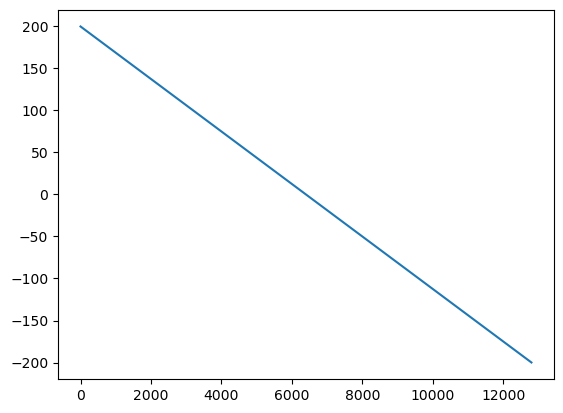

In [30]:
plt.plot(zarray)

In [69]:
ar = ar.numpy()

In [70]:
ar

array([20702.73 , 20695.818, 20692.186, ..., 99197.62 , 99222.47 ,
       99243.32 ], dtype=float32)

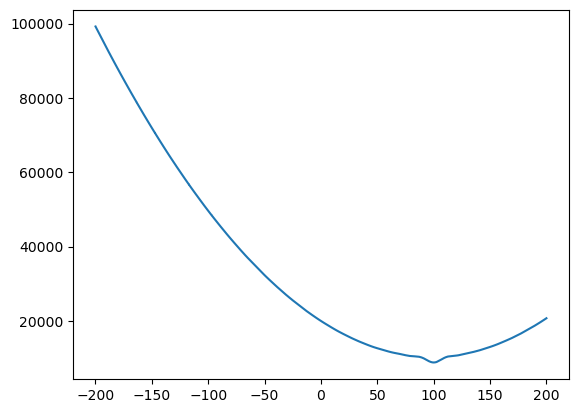

In [71]:
plt.plot(zarray,ar)

In [15]:
index_true_list = tf.map_fn(lambda y: find_z_ind(Y[:,1], y), Y_test[:,1], dtype=tf.int64)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [16]:
index_true_list.shape

TensorShape([2102, 10510])

In [17]:
find_z_ind(Y[:,1], Y_test[0,1])

<tf.Tensor: shape=(10510,), dtype=int64, numpy=array([0, 0, 0, ..., 0, 0, 0])>

In [18]:
Y_test[0,1].shape

(1,)

In [19]:
index_pred_list = tf.map_fn(lambda y: find_z_ind(zarray, y), Y_test[:,1], dtype=tf.int64)

In [20]:
index_pred_list.shape

TensorShape([2102])

array([99.13889214])

In [45]:
i = 100
z = Y_val[i,1][0]
z

89.2037560719968

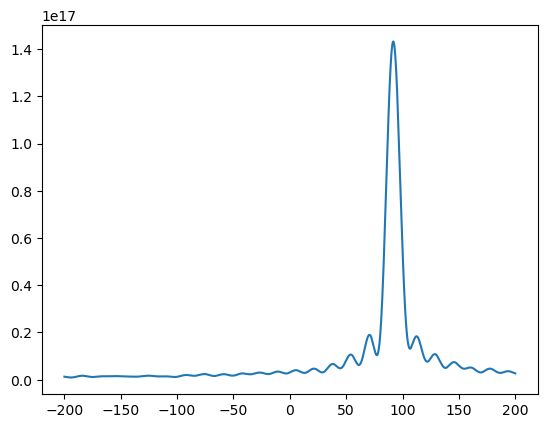

In [46]:
plt.plot(zarray,rslices[i])

(0.0, 6000.0)

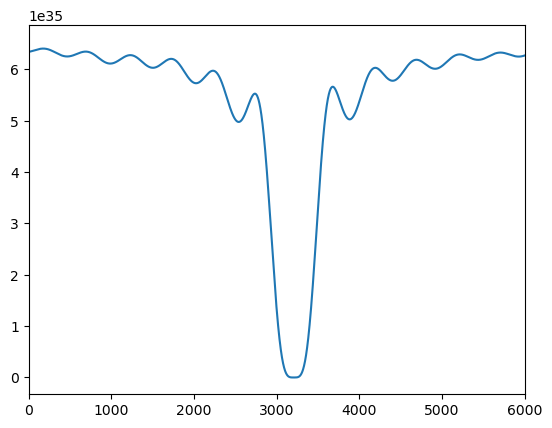

In [55]:
plt.plot((rslices[i] - np.max(rslices[i]))**2)
plt.xlim(0,6000)

(0.0, 6000.0)

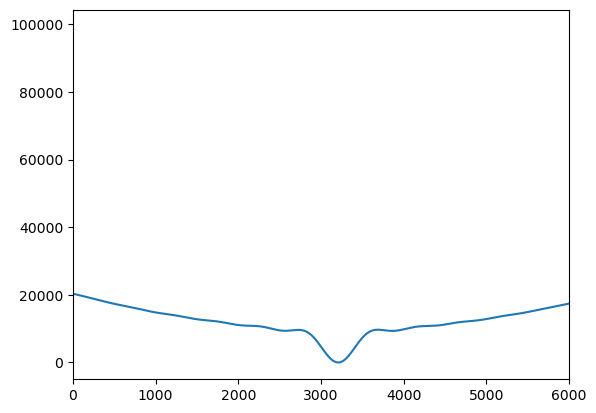

In [54]:
i = 6
z = Y_val[i,1][0]
sci = 1 - rslices[i]/np.max(rslices[i])
mse = np.power(zarray - z,2)
fact = (200 - z)**2
plt.plot(mse + fact*sci.numpy())
plt.xlim(0,6000)

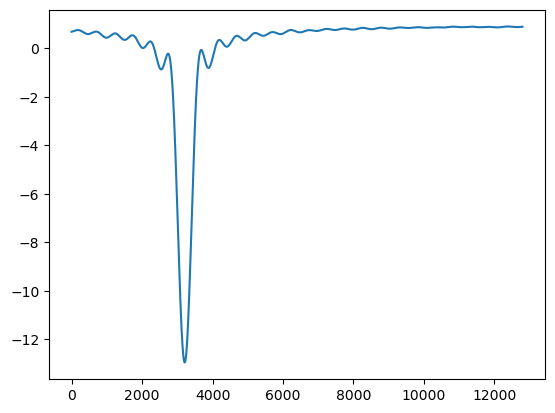

In [32]:
plt.plot(sci.numpy())